开始日期,2017-11-29
结束日期,2024-12-17
总月数,84
,回测
年化收益率,160.99%
年化波动率,48.09%
夏普比率,2.23
Calmar 比率,3.97
Omega 比率,1.56
Sortino 比率,3.95
累计收益率,81096.28%


最差回撤期间,净回撤比率%,高点日期,低点日期,恢复日期,期间长度
0,40.53,2018-12-14,2019-06-26,2019-10-23,224
1,38.15,2021-08-03,2021-11-08,2022-01-22,124
2,34.56,2018-06-13,2018-07-24,2018-11-14,111
3,20.40,2024-06-05,2024-07-07,2024-09-10,70
4,20.12,2018-02-05,2018-03-05,2018-03-08,24


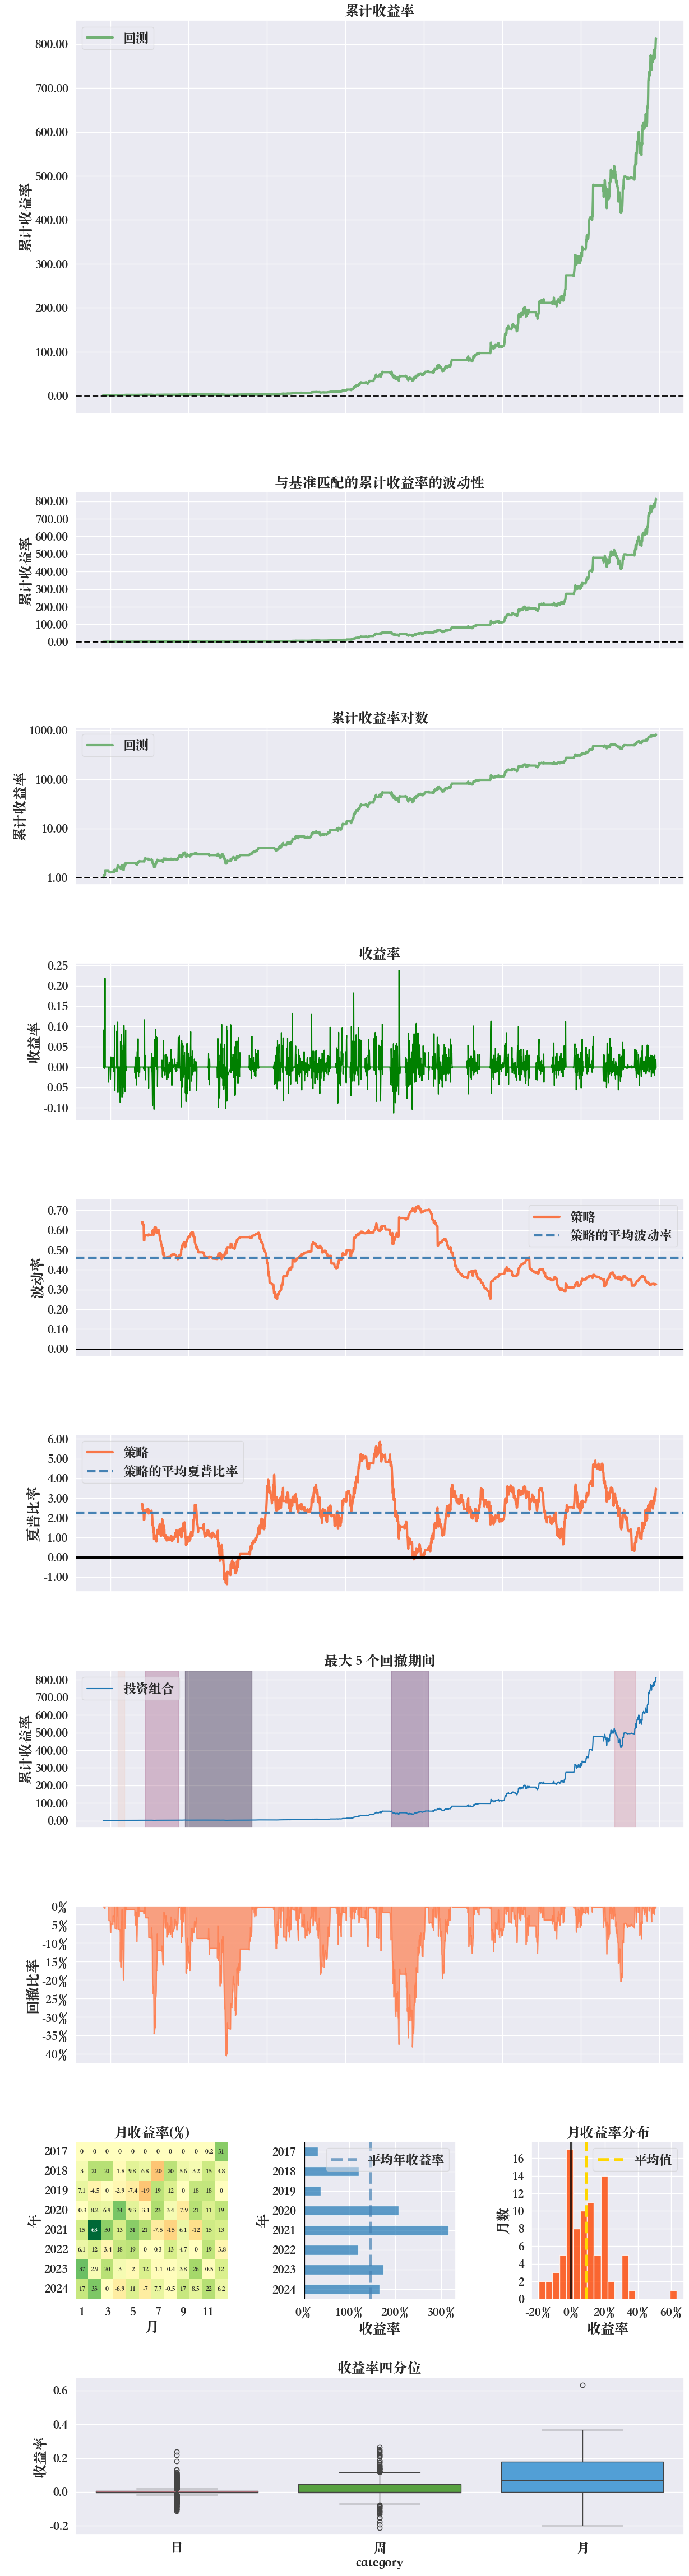

In [2]:
# %%

import pyfolio as pf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')
bitcoin_strategy_backtest = pd.read_csv('bitcoin_strategy_backtest.csv', index_col=0, parse_dates=True)
returns = bitcoin_strategy_backtest['returns']
#print(returns.head())
pf.create_returns_tear_sheet(returns)
plt.show()


In [ ]:

bitcoin_strategy_backtest['positions'] = bitcoin_strategy_backtest['positions'].apply(lambda x: x.replace("'", '"'))
bitcoin_strategy_backtest['transactions'] = bitcoin_strategy_backtest['transactions'].apply(lambda x: x.replace("'", '"'))
bitcoin_strategy_backtest['transactions'] = bitcoin_strategy_backtest['transactions'].apply(lambda x: x.replace("datetime.", '"datetime.'))
bitcoin_strategy_backtest['transactions'] = bitcoin_strategy_backtest['transactions'].apply(lambda x: x.replace(")", ')"'))

positions = bitcoin_strategy_backtest[['positions', 'ending_cash']]
position_data = json.loads(positions.iloc[1, 0])

symbol = position_data[0]['symbol']
positions_edited = pd.DataFrame(0, index = positions.index, columns = [[symbol, 'cash']])
for index, row in positions.iterrows():
    position_data = json.loads(row['positions'])

    if position_data:
        positions_edited.loc[index, symbol] = position_data[0]['amount']   
    positions_edited.loc[index, 'cash'] = int(row['ending_cash'])
#print(positions_edited.head()) 

transactions = bitcoin_strategy_backtest[['transactions']]
transactions_edited = pd.DataFrame(np.nan, index = transactions.index, columns = [['amount', 'price', 'symbol']])
transactions_edited['symbol'] = transactions_edited['symbol'].astype(str)

for index, row in transactions.iterrows():
    #print('index: ', index, "row['transactions']: ", row['transactions'])
    transactions_data = json.loads(row['transactions'])
    if transactions_data:
        transactions_edited.loc[index, 'price'] = float(transactions_data[0]['price'])   
        transactions_edited.loc[index, 'amount'] = transactions_data[0]['amount']           
        transactions_edited.loc[index, 'symbol'] = symbol
    else:
        transactions_edited.loc[index, 'price'] = 0
        transactions_edited.loc[index, 'amount'] = 0
        transactions_edited.loc[index, 'symbol'] = symbol   
transactions_edited = transactions_edited.dropna()
#print(returns.head())
#print(positions.head())
#print(transactions_edited.dtypes)

pf.create_full_tear_sheet(returns,
                          positions=positions_edited,
                          transactions=transactions_edited,
                          slippage=1)
plt.show()